# Convolutional Neural Networks: a recipe with PyTorch

---

## 📖 Introduction

Convolution Neural Networks (CNNs) are a class of deep learning models specifically designed for processing data with a grid-like topology, such as images. CNNs have revolutionized the field of computer vision by achieving state-of-the-art results in tasks like image classification, object detection, and segmentation.

The key idea behind CNNs is the use of convolutional layers, which apply filters to local regions of the input data to extract hierarchical features. These layers are typically followed by pooling layers that reduce the spatial dimensions, making the network more efficient and robust to spatial variations.

CNNs are composed of several types of layers:
- **Convolutional Layers:** Extract local features using **learnable** filters.
- **Activation Functions:** Introduce non-linearity (commonly ReLU).
- **Pooling Layers:** Downsample feature maps to reduce computation and control overfitting.
- **Fully Connected Layers:** Combine features for final classification or regression tasks.

Due to their ability to automatically learn spatial hierarchies of features, CNNs are widely used in image and video analysis, medical image processing, and many other domains.

<div align="center">
<img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/b6/f4/variational-autoencoder-neural-network.component.xl.ts=1744887318491.png/content/adobe-cms/us/en/think/topics/latent-space/jcr:content/root/table_of_contents/body-article-8/image" width="600">
</div>

---

**Visualizing a model with Netron** 

Below you can reconstruct a model architecture using Netron package.
Netron notation works like this:

`W <C_out×C_in×K>`
* **C\_out**: Number of filters (output channels).
* **C\_in**: Number of input channels.
* **K**: Kernel size (window length).

Example: `W <16×1×5>` indicates 16 filters, each looking at 1 channel with a window of length 5.

---

In [ ]:
import os
# Install required packages if needed
try:
    import netron
    import seaborn as sns
    import matplotlib.pyplot as plt
    import torch
    import torch.nn as nn
    import pandas as pd
except ImportError:
    os.system('pip install onnx netron seaborn matplotlib torch')

sns.set_theme(style="whitegrid")
sns.set_style("whitegrid")

In [ ]:
SCRIPT_DIR = os.getcwd()
PYISV_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, '..'))

models_dir = os.path.join(PYISV_ROOT, 'models')

onnx_path = f"{models_dir}/20250517_203607/model.onnx"
netron.start(onnx_path)
# This will open a browser window with the model visualization.

Serving '/Users/frasera/Ricerca/PyISV/models/best_autoencoder_model.onnx' at http://localhost:21103


('localhost', 21103)

---

## 🔀 Convolutional layers

Convolutional layers in neural networks are specialized layers designed to automatically and efficiently extract spatial **features** from input data, typically images. They use filters (**kernels**) that slide over the input to detect patterns like edges, textures, or shapes. Each filter produces a **feature map** highlighting where specific features appear. These layers reduce the number of parameters and preserve spatial relationships, making them ideal for tasks like image recognition.

During training, **convolutional layers** work by **learning the filter weights** that best detect useful features for the task (e.g., classification, dimensionality reduction). Here's how a simple neural network works:

1. **Convolution Operation**:
   A filter (a small matrix of weights) slides over the input (like an image), performing element-wise multiplication and summing the result to produce a **feature map**.

2. **Activation Function**:
   The output goes through a non-linear function (like ReLU) to introduce non-linearity.

3. **Backpropagation**:
   After forward propagation, the network calculates a **loss** (e.g., difference between predicted and true labels).
   Using **backpropagation**, it computes gradients of the loss with respect to the filter weights.

4. **Weight Update**:
   Filters are updated using an optimizer (e.g., SGD or Adam), adjusting weights to reduce the loss.

Over time, filters in early layers learn to detect simple features (like edges in images), while deeper layers capture complex patterns (like shapes or objects), all automatically during training.


### Torch Tensor Shapes

In PyTorch, a 1D convolutional layer expects input tensors of shape:

```
(batch_size, in_channels, signal_length)
```

* **batch\_size**: Number of samples processed in parallel.
* **in\_channels**: Number of feature maps per sample (channels).
* **signal\_length**: Number of discrete steps per sample (e.g., time steps or histogram bins).

A 2D input would include another dimension: signal_height.

**Example:** A batch of 32 KDE feature vectors with one channel and 100 bins has shape `(32, 1, 100)`.

In [ ]:
# Example: batch of 32 KDE feature vectors, 1 channel, 100 bins
import torch
batch_size = 32 
in_channels = 1
signal_length = 100
x = torch.randn(batch_size, in_channels, signal_length)
print("Input shape:", x.shape)  # Output: torch.Size([32, 1, 100])

Input shape: torch.Size([32, 1, 100])


### Channels vs Spatial Dimensions

* **Channels** represent parallel feature sequences (different maps) stacked along the channel axis, each learned by a separate filter.
* **Spatial dimensions** (length, for 1D) represent the position or order in the input signal that filters slide over.

> **Note:** Visualization tools like Netron may display 1D data as an image of size `1×1×signal_length`, treating bins as channels. In practice for Conv1d, interpret `(in_channels, signal_length)` directly.

In Torch a 1d convolutional layerset layer is set by:
```python
nn.Conv1d(in_channels=C_in,
          out_channels=C_out,
          kernel_size=K)
```
* **C\_in**: Number of input channels.
* **C\_out**: Number of filters, and thus output channels.
* **K**: Kernel size—i.e., the length of the sliding window on the input signal.

The weight tensor has shape:

```
(C_out, C_in, K)
```

and the bias tensor (if used) has shape:

```
(C_out,)
```

> **Kernel window example:** If `kernel_size = 3`, each filter examines 3 consecutive steps in the signal (e.g., bins 5–7) at each position.

* The layer contains `C_out` filters, each with its own weights and bias.
* All filters scan the full input in parallel, producing `C_out` feature maps.
* These feature maps are stacked along the output channel axis, yielding an output tensor of shape `(batch_size, C_out, L_out)`.
* Each filter has one bias scalar added to its output at every position:
  $\text{output} = \text{activation}(w \cdot x + b)$
* Bias allows the activation function to shift, improving the model's flexibility.
* There are `C_out` biases in total.

In [ ]:
import torch.nn as nn
# Define a Conv1d layer
conv = nn.Conv1d(in_channels=1,    # Number of input channels
                out_channels=16,  # Number of output channels
                kernel_size=5,     # Size of the convolutional kernel ()
                stride=1,          # Stride of the convolution operation (how many positions to move the kernel at each step)
                padding=1,         # Padding added to both sides of the input
                bias=True)         # Whether to include a bias term
print("Weight shape:", conv.weight.shape)  # torch.Size([16, 1, 5])
print("Bias shape:", conv.bias.shape)      # torch.Size([16])

Weight shape: torch.Size([16, 1, 5])
Bias shape: torch.Size([16])


### Convolution Parameters: Stride, Padding, Dilation, and Bias

- **Stride** is a key parameter in convolutional layers that determines how far the filter (kernel) moves at each step as it slides across the input signal.

    - **stride=1**: The filter moves one position at a time, covering every possible location. This results in the most detailed output (largest output length).
    - **stride >1**: The filter jumps n positions at a time, skipping some positions. This reduces the output length and acts as a form of downsampling.

    A smaller stride (e.g., 1) means more overlap between filter applications, producing a larger output. A larger stride (e.g., 2 or more) means less overlap, producing a smaller output and reducing computation.

- **Padding** adds zeros to the edges of the input signal before applying the convolution. This allows the filter to cover the borders of the input and can control the output size:

    - **padding=0**: No padding. The output will be smaller than the input, depending on kernel size and stride.
    - **padding>0**: Zeros are added to both sides of the input. This can preserve the input length ("same" padding) or simply reduce the amount by which the output shrinks.

    Padding is useful when you want the output to have the same length as the input, or to control how much the borders are affected by the convolution.

- **Bias** is an additional learnable parameter added to the output of each filter after the convolution operation. Each output channel (filter) has its own bias value:

    - The bias allows the network to shift the activation function, making the model more flexible.
    - In PyTorch, setting `bias=True` (the default) means each filter will have a bias term added to its output at every position.

- **Dilation** controls the spacing between the elements in the convolutional kernel as it slides over the input signal.

    - **dilation=1** (default): The kernel is applied to consecutive input elements, with no gaps. For example, a kernel of size 3 covers positions `[i, i+1, i+2]` at each step.
    - **dilation>1**: The kernel skips input elements, creating gaps between the sampled positions. For example, with `dilation=2` and `kernel_size=3`, the kernel covers `[i, i+2, i+4]` at each step.

    Dilation allows the convolution to have a larger "receptive field" (see more of the input) without increasing the kernel size or the number of parameters. This is useful for capturing long-range dependencies or patterns in the input, especially in tasks like audio, time series, or sequence modeling.

### Output shape
After applying a series of tensor operations, the output length can be calculated by:

$L_{out} = \text{floor}((L_{in} + 2*\text{padding} - \text{dilation}*(\text{kernel}-1) - 1)/\text{stride}) + 1$

where:
- $L_{in}$ = input length
- padding = number of zeros added to each side
- dilation = spacing between kernel elements (default 1)
- kernel_size = size of the filter
- stride = step size

### 🌰  In a nutshell 🌰 
- **Stride** controls how much the filter "jumps" at each step. A larger stride means more downsampling and a smaller output, while a stride of 1 gives the most detailed output.
- **Padding** controls the spatial size of the output and how the borders are handled.
- **Bias** allows each filter to shift its output, improving the model's ability to fit the data.
- **Dilation** parameter stretches the kernel by inserting spaces between its elements, enabling the network to look at wider contexts in the input signal.

In [6]:
import torch
import torch.nn as nn

# Input: batch_size=32, in_channels=1, signal_length=100
x = torch.randn(32, 1, 100)
conv = nn.Conv1d(in_channels=1,
                 out_channels=16,
                 kernel_size=3,
                 stride=2,
                 padding=2,
                 dilation=2,
                 bias=True)
y = conv(x)
print("Output shape:", y.shape)

# L_out = floor((L_in + 2*padding - dilation*(kernel_size-1) - 1)/stride) + 1
# L_out = floor((100 + 2*2 - 2*(3-1) - 1)/2) + 1 = floor(49.5) = 50

Output shape: torch.Size([32, 16, 50])


<div align="center">
<img src="https://www.cs.cmu.edu/~bhiksha/courses/deeplearning/Spring.2019/archive-f19/www-bak11-22-2019/document/note/hwnotes/hw2/images/image13.gif" width="600">
</div>

--- 

## 🔢 Activation Functions, Pooling and Batch Normalization

After each convolution operation in a CNN, the result typically passes through an **activation function** to introduce non-linearity, and then optionally through a **pooling layer** to reduce the signal length and focus on important features.

An activation function transforms the output of a convolution (or any linear layer) to make the network capable of learning **non-linear relationships** in the data. Without activations, a neural network would behave like a linear regression model regardless of its depth.

Activations operate **element-wise** on the output of each filter:

```python
x = conv_output  # shape: (batch_size, channels, length)
x = activation_fn(x)
```

Each position in each feature map is transformed independently.

### Common Activation Functions

| Name       | Formula                            | Purpose / Effect                         |
|------------|-------------------------------------|------------------------------------------|
| ReLU       | `f(x) = max(0, x)`                  | Keeps positive values, zeroes out others |
| Leaky ReLU | `f(x) = x if x > 0 else αx`         | Allows a small gradient when x < 0       |
| Tanh       | `f(x) = (e^x - e^-x) / (e^x + e^-x)` | Squashes input to [-1, 1]                |
| Sigmoid    | `f(x) = 1 / (1 + e^-x)`             | Squashes input to [0, 1]                 |

<br>
<br>

<div align="center">
<img src="https://images.prismic.io/encord/96630d33-5206-4c76-84f9-8b57aabee7c1_CNN+2.png?auto=compress,format" width="500">
</div>

<br>
<br>

> **ReLU** is the most widely used in modern CNNs due to its simplicity and efficiency in training.

### Fully connected layer after Activation

After applying an activation function, it is common to use a fully connected (dense) layer such as `nn.Linear`. This layer mixes information across all features (or channels) and enables the network to learn more abstract, global representations. In 1D CNNs, this is typically done after flattening the output of the convolutional and pooling layers, before the final prediction or embedding.

- **Convolutional layers** extract local features.
- **Activation functions** introduce non-linearity.
- **Linear (fully connected) layers** combine features globally and enable the network to learn complex relationships.

This combination is essential for tasks like classification, regression, or learning embeddings.

In [44]:
# Example: Applying activation functions after Conv1d
import torch
import torch.nn as nn

x = torch.randn(8, 4, 50)  # (batch_size, channels, length)
conv = nn.Conv1d(4, 8, kernel_size=3)
out = conv(x)

# ReLU activation
relu = nn.ReLU()
out_relu = relu(out)
print('After ReLU:', out_relu.shape)

# Tanh activation
tanh = nn.Tanh()
out_tanh = tanh(out)
print('After Tanh:', out_tanh.shape)

# Using nn.Linear after activation
# Suppose we want to map the features to a new space after flattening
out_flat = out_relu.view(out_relu.size(0), -1)  # Flatten to (batch_size, features)
linear = nn.Linear(out_flat.size(1), 16)  # Map to 16 features
out_linear = linear(out_flat)
print('After Linear:', out_linear.shape)  # (batch_size, 16)

# This is typical before a final output or embedding layer in a CNN pipeline

After ReLU: torch.Size([8, 8, 48])
After Tanh: torch.Size([8, 8, 48])
After Linear: torch.Size([8, 16])


### Pooling and Upsampling

Pooling is a **downsampling operation** that reduces the spatial size (i.e., length) of the feature maps while keeping the most important information. It helps with:

* **Reducing computation**
* **Improving generalization**
* **Making the network more robust to small shifts or noise**

### Types of Pooling

| Type        | Operation                          | Example                    |
| ----------- | ---------------------------------- | -------------------------- |
| Min Pool    | Takes the minimum in a window      | `[1, 5, 3] → min = 1`      |
| Max Pool    | Takes the maximum in a window      | `[1, 5, 3] → max = 5`      |
| Avg Pool    | Takes the average in a window      | `[1, 5, 3] → avg = 3`      |
| Global Pool | Reduces entire signal to one value | Useful before dense layers |

<br>
<br>

<div align="center">
<img src="https://epynn.net/_images/pool-01.svg" width="600">
</div>

**Upsampling** is the opposite operation that **increases the spatial size** of feature maps to restore resolution lost during pooling or to generate higher-resolution outputs. It is useful in tasks like image segmentation or generation, where fine spatial details are important.

### Common Upsampling Methods

| Type                   | Operation                                                    |
| ---------------------- | ------------------------------------------------------------ |
| Nearest Neighbor       | Repeats nearest pixel to enlarge the feature map             | Simple and fast but can cause blocky artifacts         |
| Bilinear Interpolation | Uses weighted averages of nearby pixels for smoother results | Produces smoother, more natural outputs                |
| Transposed Convolution | Learnable upsampling via convolution-like operations         | Allows the network to learn optimal upsampling filters |



A pooling layer (e.g., `nn.MaxPool1d`) is defined by:
```python
nn.MaxPool1d(kernel_size, stride)
```
- **kernel_size**: Size of the pooling window.
- **stride**: Step size to move the window. Default is `stride = kernel_size`.

An upsampling layer can be set with:
```python
nn.Upsample(scale_factor, mode)
```
- **scale_factor**: Defines how much to enlarge the input along each spatial dimension.
- **mode**: Specifies the algorithm used to compute the upsampled values. Default is `mode=nearest`

Given input of shape `(batch_size, channels, $L_{in}$)`, pooling reduces the length to:

$L_{out} = \text{floor}((L_{in} - \text{kernel}) / \text{stride}) + 1$,

while for upsampling, it depends on the method. The number of channels remains the same.

### Batch Normalization

**Batch normalization** is a technique that normalizes the activations of each layer to have zero mean and unit variance within each mini-batch. This helps to:
- Accelerate training by reducing internal covariate shift.
- Improve stability and convergence of deep networks.
- Allow for higher learning rates and less careful initialization.

In 1D CNNs, `nn.BatchNorm1d(num_features)` is typically placed **after each convolutional layer and before the activation function**. For autoencoders, you can also use `BatchNorm1d` after `ConvTranspose1d` layers in the decoder.

**Example usage:**
```python
nn.Sequential(
    nn.Conv1d(in_channels, out_channels, ...),
    nn.BatchNorm1d(out_channels),
    nn.ReLU(),
    ...
)
```

Batch normalization is especially helpful when training on diverse or noisy data, as it makes the network less sensitive to the scale and distribution of the input features.

> **Tip:** You usually do **not** use batch normalization on the final output layer of the decoder, since you want the output to match the original data distribution.

### Combining Activation and Pooling

A common sequence in CNNs is:

1. **Convolution** 
2. **Batch Normalization**
3. **Activation** (e.g., ReLU, LeakyReLU)  
4. **Pooling** (e.g., MaxPool1d)

This pattern is repeated in layers to progressively extract and condense features.
For an 1D CNN, the Torch corresponding torch functions would be:

```python
1. Conv1d() or ConvTranspose1d() # The transpose is used in the decoder layer
2. BatchNorm1d()
3. ReLU() # or any other, e.g. Sigmoid()
4. MaxPool1d() # or any other, e.g. MinPool1d
```

And adding a fully connected (usually linear) layer in the bottleneck. 
Each step contributes to learning increasingly abstract representations while reducing the signal size.

In [ ]:
# Example: Full sequence - Conv1d, BatchNorm, Activation, Pooling, Dense Layer, 
import torch
import torch.nn as nn

x = torch.randn(8, 4, 50)  # (batch_size=8, in_channels=4, input_length=50)

model = nn.Sequential(
    # Conv1d layer:
    # Input: (N, C_in=4, L=50)
    # Output channels: 8
    # Kernel size: 3
    # No padding, stride=1 (default)
    # Output length = 50 - 3 + 1 = 48
    # Output shape: (N, C_out=8, L=48)
    nn.Conv1d(4, 8, kernel_size=3),

    # BatchNorm1d: keeps shape (N, 8, 48)
    nn.BatchNorm1d(8),

    # ReLU: keeps shape (N, 8, 48)
    nn.ReLU(),

    # MaxPool1d with kernel_size=2, stride=2 (default)
    # Output length = floor((48 - 2)/2 + 1) = floor(23.5) = 24
    # Output shape: (N, 8, 24)
    nn.MaxPool1d(kernel_size=2),

    # Flatten the tensor to prepare for Linear layer
    # Flattened size = 8 (channels) * 24 (length) = 192
    nn.Flatten(),

    # Linear layer input features must match the flattened size
    nn.Linear(8 * 24, 16)
)

out = model(x)
print('After Conv1d, BatchNorm, ReLU, MaxPool1d:', out.shape)

After Conv1d, BatchNorm, ReLU, MaxPool1d: torch.Size([8, 16])


### 🌰 In a nutshell 🌰 

* **Channels**: parallel feature sequences (axis after batch).
* **Signal length**: spatial dimension scanned by filters.
* **Filters**: learnable weight sets of shape `(C_out, C_in, K)`.
* **Biases**: one per filter to shift activations.
* **Output**: tensor of shape `(batch_size, C_out, L_out)`.
* **Activation functions** introduce non-linearity and are applied after convolutions.
* **ReLU** is the default choice in most CNN architectures.
* **Pooling layers** reduce signal length, improving efficiency and robustness. Pooling is applied per channel and does not mix information across channels.
* **Batch normalization** normalizes activations and accelerate training by reducing internal covariate shift.


---

## 🔍 Embeddings and Latent Space in Neural Networks

### What is an Embedding?

An **embedding** is a learned, low-dimensional representation of high-dimensional data. In neural networks, especially autoencoders, the embedding is the output of the network's bottleneck (the layer with the smallest number of neurons). This compact vector captures the most salient features of the input data.

### The Latent Space

The **latent space** is the space of all possible embeddings. Each point in this space corresponds to a compressed version of an input sample. The structure of the latent space reflects the relationships and similarities between different inputs as learned by the network.

<div align="center">
<img src="https://www.mdpi.com/sensors/sensors-23-01057/article_deploy/html/images/sensors-23-01057-g004.png" width="500">
</div>

For example, in an autoencoder trained on RDFs (radial distribution functions) of metal nanoclusters, each RDF is mapped to a point in the latent space. Similar RDFs (e.g., from similar cluster structures) will be close together, while very different RDFs will be far apart.

### Why Low-Dimensional Representations?

* **Visualization:** Reducing complex, high-dimensional data to 2D or 3D allows us to visualize patterns, clusters, and outliers.
* **Noise Reduction:** The network learns to ignore irrelevant details, focusing on the most important features.
* **Data Compression:** Storing or transmitting the embedding is much more efficient than the full input.
* **Downstream Tasks:** Embeddings can be used as input features for classification, clustering, or regression tasks, often improving performance and interpretability.

### Embedding Metal Nanocluster RDFs

Radial Distribution Functions (RDFs) are one of many ways of analyzing the structure of metal nanoclusters. Although they can serve as informative structural identifiers, RDFs are often high-dimensional and difficult to interpret directly.

By training an autoencoder, we can map each RDF to a low-dimensional embedding (e.g., 2D or 3D), making it possible to:

* **Cluster similar structures:** Nanoclusters with similar atomic arrangements produce similar RDFs and are mapped to nearby points in the latent space.
* **Detect anomalies:** Outliers in the latent space may correspond to rare, unstable, or defective structures.
* **Visualize structure-property relationships:** By coloring embeddings according to physical properties (e.g., energy, radius of gyration), we can uncover how structure correlates with function.
* **Identify collective variables:** These learned embeddings can serve as collective variables in biased molecular dynamics simulations, improving sampling of structural transitions and rare events.

### 🌰  In a nutshell 🌰 

* **Embeddings** provide a compact, information-rich summary of complex data.
* **Latent space** structure reveals relationships, clusters, and anomalies in the data.
* For metal nanocluster RDFs, low-dimensional embeddings enable visualization, clustering, and improved analysis of structural diversity.

---

## 🔧 How a Training Algorithm Works: Encoding, Decoding, Targets, and Loss Functions

Training a neural network (including autoencoders) is an iterative process where the model learns to map inputs to desired outputs by adjusting its internal weights. Here’s how the process works step by step:

1. **Forward Pass:**
   - The input data is passed through the network (encoder, embedding (bottleneck) and decoder for autoencoders).
   - The decoder reconstructs the input from the compressed embedding (called a latent space or a bottleneck in terms of NN architecture).

2. **Targets:**
   - For autoencoders, the target is usually the original input itself (the network tries to reconstruct what it saw).
   - For other tasks (e.g., classification), the target would be a label or value.

3. **Loss Function:**
   - The loss function measures how different the network’s output (prediction) is from the target.
   - Common loss for autoencoders: **Mean Squared Error (MSE)**, which penalizes large differences between the input and its reconstruction.

4. **Backward Pass (Backpropagation):**
   - The network computes gradients of the loss with respect to each weight.
   - These gradients indicate how to change the weights to reduce the loss.

5. **Optimizer Step:**
   - The optimizer (e.g., Adam, SGD) updates the weights using the gradients.

6. **Repeat:**
   - This process is repeated for many epochs (passes over the data), gradually improving the network’s performance.

<br>
<br>

<div align="center">
   <span style="font-size: 22px;"><b>Visual summary</span></b>
</div>

<div align="center">
   <img src="https://www.mathworks.com/discovery/autoencoder/_jcr_content/mainParsys/image.adapt.480.medium.svg/1740722140318.svg" width="600">
</div>




The loss function compares the output to the target and guides the network to improve its reconstruction (or prediction) ability.

---

##  📊 End-to-End Example: Training and Visualizing a Simple Autoencoder Embedding

This example shows how to train the simple autoencoder on random (dummy) RDF data, extract the 2D embeddings, and visualize the latent space. Replace the dummy data with your real RDF dataset for actual use.

In [155]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels: int, input_length: int, embedding_dim: int = 2) -> None:
        super().__init__()
        self.input_length = input_length

        # Deeper multi-scale encoder: alternate small and large kernels, more layers and pooling
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(input_channels, 8, kernel_size=3, stride=1, padding=1),   # small kernel
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.1),
            nn.Conv1d(8, 16, kernel_size=7, stride=1, padding=3),               # large kernel
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(kernel_size=2, stride=2),                              # pooling 1
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),              # small kernel
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3),              # large kernel
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(kernel_size=2, stride=2),                              # pooling 2
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),             # small kernel
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),             # small kernel
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
        )

        # Calculate output length after pooling
        def conv1d_out_length(L_in, kernel_size, stride, padding, dilation=1):
            return int(np.floor((L_in + 2*padding - dilation*(kernel_size-1) - 1)/stride) + 1)
        l1 = input_length
        l2 = conv1d_out_length(l1, 3, 1, 1)
        l3 = conv1d_out_length(l2, 7, 1, 3)
        l4 = conv1d_out_length(l3, 2, 2, 0)  # pooling 1
        l5 = conv1d_out_length(l4, 3, 1, 1)
        l6 = conv1d_out_length(l5, 7, 1, 3)
        l7 = conv1d_out_length(l6, 2, 2, 0)  # pooling 2
        l8 = conv1d_out_length(l7, 3, 1, 1)
        l8 = conv1d_out_length(l8, 3, 1, 1)

        self.encoder_linear = nn.Linear(128 * l8, embedding_dim)
        self.bottleneck = nn.Sequential(
            nn.Linear(embedding_dim, 128 * l8),
            nn.LeakyReLU(0.1)
        )

        # Deeper decoder: mirror the encoder
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(128, 128, kernel_size=3, stride=1, padding=1),   # small kernel
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=1, padding=1),    # small kernel
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='nearest'),                        # upsample 1
            nn.ConvTranspose1d(64, 32, kernel_size=7, stride=1, padding=3),     # large kernel
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=1, padding=1),     # small kernel
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='nearest'),                        # upsample 2
            nn.ConvTranspose1d(16, 8, kernel_size=7, stride=1, padding=3),      # large kernel
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(8, input_channels, kernel_size=3, stride=1, padding=1), # small kernel
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        z = self.encoder_conv(x)
        z_flat = z.view(z.size(0), -1)
        embed = self.encoder_linear(z_flat)
        z_recon = self.bottleneck(embed)
        z_recon = z_recon.view(z.size(0), 128, z.size(2))
        recon = self.decoder_conv(z_recon)
        if recon.size(2) > self.input_length:
            recon = recon[:, :, :self.input_length]
        elif recon.size(2) < self.input_length:
            pad_amt = self.input_length - recon.size(2)
            recon = nn.functional.pad(recon, (0, pad_amt))
        return recon, embed

Dataset shape: torch.Size([630, 100])
labels shape: torch.Size([630])
Label counts: {0: 300, 1: 300, 2: 30}


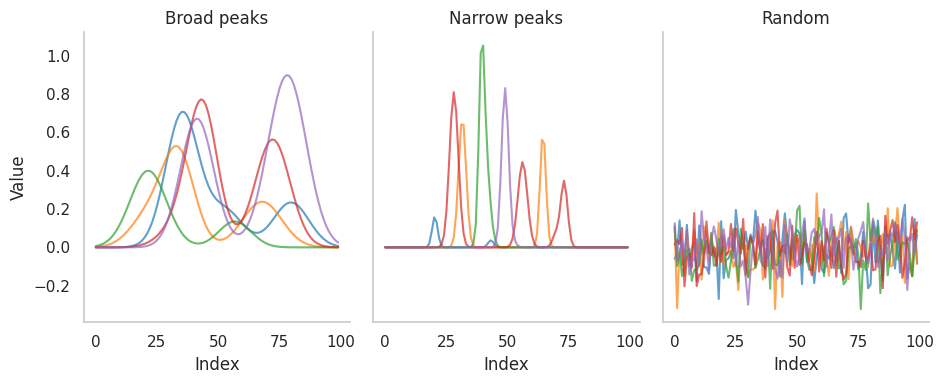

In [156]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter1d

input_dim = 100
n_samples_per_set = {'broad': 300, 'narrow': 300, 'random': 30}
n_sets = 3  # 0: broad peaks, 1: narrow peaks, 2: random

X_list = []
labels = []

# Smoothing parameter (higher = smoother)
kde_sigma = 0.2

# 1. Broad peaks
for _ in range(n_samples_per_set['broad']):
    x = np.zeros(input_dim)
    n_peaks = np.random.randint(2, 5)
    for _ in range(n_peaks):
        center = np.random.uniform(20, 80)
        width = np.random.uniform(6, 8)  # broad
        height = np.random.uniform(0, 0.7)
        x += height * np.exp(-0.5 * ((np.arange(input_dim) - center) / width) ** 2)
    x = gaussian_filter1d(x, sigma=kde_sigma)
    X_list.append(x)
    labels.append(0)

# 2. Narrow peaks
for _ in range(n_samples_per_set['narrow']):
    x = np.zeros(input_dim)
    n_peaks = np.random.randint(2, 5)
    for _ in range(n_peaks):
        center = np.random.uniform(20, 80)
        width = np.random.uniform(1, 2)  # narrow
        height = np.random.uniform(0, 1)
        x += height * np.exp(-0.5 * ((np.arange(input_dim) - center) / width) ** 2)
    x = gaussian_filter1d(x, sigma=kde_sigma)
    X_list.append(x)
    labels.append(1)

# 3. Randomized signals
for _ in range(n_samples_per_set['random']):
    x = np.random.normal(0, 0.1, input_dim)
    x = gaussian_filter1d(x, sigma=kde_sigma)
    X_list.append(x)
    labels.append(2)

X = np.vstack(X_list)
labels = np.array(labels)

# Convert to torch tensors
dataset = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)

print('Dataset shape:', dataset.shape)
print('labels shape:', labels.shape)
print('Label counts:', {i: (labels == i).sum().item() for i in range(n_sets)})


# Prepare a DataFrame for seaborn
df_plot = pd.DataFrame(X)
df_plot['label'] = labels.numpy()
df_plot['type'] = df_plot['label'].map({0: 'Broad peaks', 1: 'Narrow peaks', 2: 'Random'})

n_show = 5
# Select n_show samples per type
show_idxs = []
for t in [0, 1, 2]:
    idxs = df_plot[df_plot['label'] == t].index[:n_show]
    show_idxs.extend(idxs)
df_melt = df_plot.loc[show_idxs].reset_index().melt(
    id_vars=['index', 'type'],
    value_vars=[i for i in range(input_dim)],
    var_name='Signal Index',
    value_name='Value'
)

g = sns.FacetGrid(df_melt, col="type", col_order=['Broad peaks', 'Narrow peaks', 'Random'], 
                  sharey=True, height=4, aspect=0.8)
g.map_dataframe(sns.lineplot, x="Signal Index", y="Value", hue="index", 
                legend=False, alpha=0.7, palette="tab10")
g.set_axis_labels("Index", "Value")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.grid(False)
    if ax.legend_:
        ax.legend_.remove()
plt.tight_layout()
plt.show()

# Collect latent space before training
model = Autoencoder(input_channels=1, input_length=input_dim, embedding_dim=3)
model.eval()
with torch.no_grad():
    _, embeddings_before = model(dataset.unsqueeze(1))
embeddings_before = embeddings_before.numpy()



In [157]:
# --- Train the autoencoder with fast convergence --- #

# Hyperparameters in the optimizer Adam:

# lr = learning rate, controls how much to change the model to
# the estimated error each time the model weights are updated.

# scheduler = learning rate scheduler, reduces the learning rate
# when a metric has stopped improving, which helps to prevent
# overfitting and improve convergence.

# weight decay = L2 regularization, technique used to prevent 
# overfitting by adding a penalty to the loss function based 
# on the size of the weights.

# n_epochs = number of times the model will see the entire dataset

# batch_size = separate the dataset into smaller batches to update 
# the model at each step, which helps to speed up the training process.

# n_samples is the total number of samples in the dataset

# loss_fn = loss function, used to calculate the error between the 
# predicted output and the actual output, and the optimizer uses this 
# error to update the model parameters.

from tqdm import tqdm

# Normalize dataset to zero mean and unit variance
mean = dataset.mean()
std = dataset.std()
dataset = (dataset - mean) / std

n_epochs = 600  # Fewer epochs for speed
batch_size = 64  # Smaller batch for more updates per epoch
embedding_dim = 3
n_samples = np.sum([n_samples_per_set[s] for s in n_samples_per_set])
print(f"Total samples: {n_samples}")

model = Autoencoder(input_channels=1, input_length=input_dim, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1e-4, factor=0.5, patience=20)
loss_fn = nn.HuberLoss()

for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(n_samples)
    batch_losses = []
    with tqdm(total=n_samples, desc=f"Epoch {epoch+1}/{n_epochs}", unit="sample", leave=False) as pbar:
        for i in range(0, n_samples, batch_size):
            # Select a batch of data
            idx = perm[i:i+batch_size]

            # Adds a new dimension regarding the number of channels
            data_batch = dataset[idx].unsqueeze(1)  # (batch, 1, length) for Conv1d

            # recon is the reconstructed signal, data_batch is the original input
            # the loss (MSE) is calculated as the mean squared error between them
            recon, _ = model(data_batch)
            loss = loss_fn(recon, data_batch) 

            # The optimizer updates the model parameters based on the loss 
            optimizer.zero_grad()

            # The backpropagation step computes the gradient of the loss
            #  with respect to the model parameters
            loss.backward()

            # The optimizer applies the gradients to the model parameters to 
            # minimize the loss function
            optimizer.step()

            batch_losses.append(loss.item())
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
            pbar.update(len(idx))
        
    # Calculate the mean loss for the epoch
    mean_loss = sum(batch_losses) / len(batch_losses)
    # Update the learning rate based on the mean loss
    scheduler.step(mean_loss)

    if (epoch+1) % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch+1}/{n_epochs} - Mean Loss: {mean_loss:.4f} - Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")


Total samples: 630


Epoch 1/600:   0%|          | 0/630 [00:00<?, ?sample/s]

Epoch 2/600 - Mean Loss: 0.2741 - Learning Rate: 5.00e-04


Epoch 25/600 - Mean Loss: 0.0796 - Learning Rate: 5.00e-04


Epoch 50/600 - Mean Loss: 0.0687 - Learning Rate: 5.00e-04


Epoch 75/600 - Mean Loss: 0.0625 - Learning Rate: 5.00e-04


Epoch 100/600 - Mean Loss: 0.0543 - Learning Rate: 5.00e-04


Epoch 125/600 - Mean Loss: 0.0468 - Learning Rate: 5.00e-04


Epoch 150/600 - Mean Loss: 0.0466 - Learning Rate: 5.00e-04


Epoch 175/600 - Mean Loss: 0.0401 - Learning Rate: 5.00e-04


Epoch 200/600 - Mean Loss: 0.0395 - Learning Rate: 5.00e-04


Epoch 225/600 - Mean Loss: 0.0417 - Learning Rate: 5.00e-04


Epoch 250/600 - Mean Loss: 0.0351 - Learning Rate: 5.00e-04


Epoch 275/600 - Mean Loss: 0.0355 - Learning Rate: 5.00e-04


Epoch 300/600 - Mean Loss: 0.0314 - Learning Rate: 5.00e-04


Epoch 325/600 - Mean Loss: 0.0292 - Learning Rate: 5.00e-04


Epoch 350/600 - Mean Loss: 0.0280 - Learning Rate: 5.00e-04


Epoch 375/600 - Mean Loss: 0.0208 - Learning Rate: 2.50e-04


Epoch 400/600 - Mean Loss: 0.0185 - Learning Rate: 1.25e-04


Epoch 425/600 - Mean Loss: 0.0167 - Learning Rate: 1.25e-04


Epoch 450/600 - Mean Loss: 0.0168 - Learning Rate: 1.25e-04


Epoch 475/600 - Mean Loss: 0.0143 - Learning Rate: 6.25e-05


Epoch 500/600 - Mean Loss: 0.0147 - Learning Rate: 6.25e-05


Epoch 525/600 - Mean Loss: 0.0138 - Learning Rate: 3.13e-05


Epoch 550/600 - Mean Loss: 0.0131 - Learning Rate: 3.13e-05


Epoch 575/600 - Mean Loss: 0.0133 - Learning Rate: 1.56e-05


Epoch 600/600 - Mean Loss: 0.0139 - Learning Rate: 7.81e-06


**Notes:**
- The autoencoder expects input of shape `(batch, channels, length)`, so we use `x_batch = X[idx].unsqueeze(1)` to add a channel dimension (channels=1).
- The number of epochs is very low, because the notebook is not ideal for running a training session. **Try to run it in a python file with more epochs and tune the parameters!**
- You can export the architecture of a model by using model.save()
It will record information about all the layers parameters used and the shapes of data being transformed.

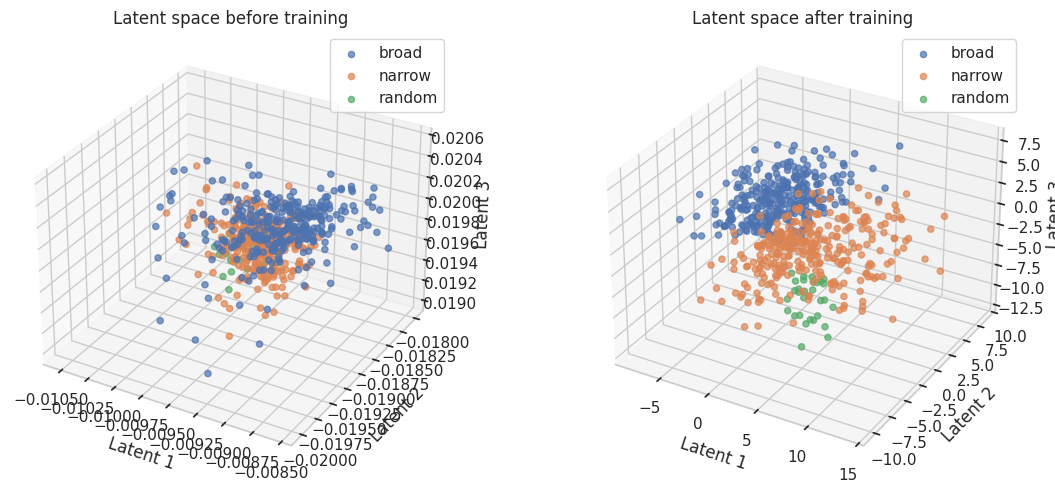

In [183]:
# After training
model.eval()
with torch.no_grad():
    _, embeddings_after = model(dataset.unsqueeze(1))
embeddings_after = embeddings_after.numpy()

# Plot both
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_comparison_3d(emb_before, emb_after, labels, label_names):
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Before training
    for label in np.unique(labels):
        idx = labels == label
        ax1.scatter(
            emb_before[idx, 0], emb_before[idx, 1], emb_before[idx, 2],
            label=label_names[label], alpha=0.7
        )
    ax1.set_title("Latent space before training")
    ax1.set_xlabel("Latent 1")
    ax1.set_ylabel("Latent 2")
    ax1.set_zlabel("Latent 3")
    ax1.legend()

    # After training
    for label in np.unique(labels):
        idx = labels == label
        ax2.scatter(
            emb_after[idx, 0], emb_after[idx, 1], emb_after[idx, 2],
            label=label_names[label], alpha=0.7
        )
    ax2.set_title("Latent space after training")
    ax2.set_xlabel("Latent 1")
    ax2.set_ylabel("Latent 2")
    ax2.set_zlabel("Latent 3")
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_latent_comparison_3d(embeddings_before, embeddings_after, labels.numpy(), ['broad', 'narrow', 'random'])

[[<Axes: > <Axes: > <Axes: >]]
<built-in function arange>


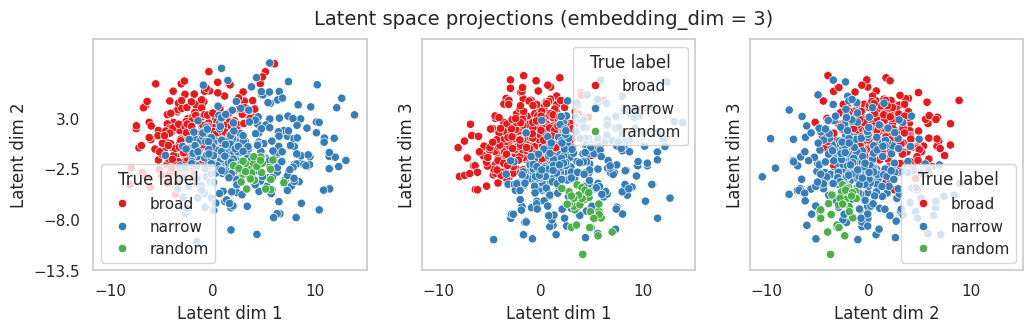

In [184]:
import itertools
import pandas as pd
import seaborn as sns

# --- Visualize the 3D embedding space in 2D projections ---

def plot_latent_space(embeddings, embed_dim, labels, label_names) -> None:
# Convert to DataFrame
    df = pd.DataFrame(embeddings, columns=[f"Latent_{i+1}" for i in range(embed_dim)])
    df['Label'] = labels
    df['LabelName'] = [label_names[i] for i in labels]

    # Generate all combinations of 2D projections
    combs = list(itertools.combinations(range(embed_dim), r=2))
    n_plots = len(combs)
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 3), sharex=True, sharey=False, squeeze=False)
    print(axes)
    for ax, (i, j) in zip(axes[0], combs):
        sns.scatterplot(
            data=df,
            x=f"Latent_{i+1}",
            y=f"Latent_{j+1}",
            hue="LabelName",
            palette="Set1",
            ax=ax,
        )
        ax.set_xlabel(f"Latent dim {i+1}")
        ax.set_ylabel(f"Latent dim {j+1}")
        ax.legend().set_title("True label")
        ax.set_yticks([])
        ax.set_ylim(-13.5,11.5)
        ax.grid(False)

    print(np.arange)
    axes[0][0].set_yticks(np.arange(-13.5, 5, 5.5))
    plt.suptitle(f"Latent space projections (embedding_dim = {embed_dim})", fontsize=14)
    plt.show()

label_names = ['broad', 'narrow', 'random']

plot_latent_space(embeddings_after, 
    embed_dim=embedding_dim, 
    labels=labels,
    label_names=label_names
)

### Latent Space Interpretation

In which latent dimension coordinates the points seem to separate better? Luckily, it can be clear from beggining, but in high-dimensional spaces, an additional dimensionality reduction (e.g. TSNE) may be necessary to visualize a clear clustering of points.

In this example, we have access to the true labels of each signal, which helps us interpret the structure of the latent space. However, it's important to note that this convolutional neural network (CNN) architecture is typically used in **unsupervised learning** settings, where such labels are not available.

To make sense of the latent representations in a truly unsupervised scenario, we would need to apply additional techniques such as **clustering** (e.g., K-means or DBSCAN) to group similar signals and uncover meaningful patterns in the data.


----

## 🔍 Clustering Data from the Embedding Space of a CNN

After training a CNN—especially in an unsupervised or self-supervised setting—we often want to interpret the learned **latent space** (also called embedding space). This space encodes meaningful features of the input data in a compressed form.

One common approach to explore structure in this space is to apply **clustering algorithms**.

Let's see how well the clustering classifies the real data for this model, without having any information whatsoever regarding the true labels of each signal.


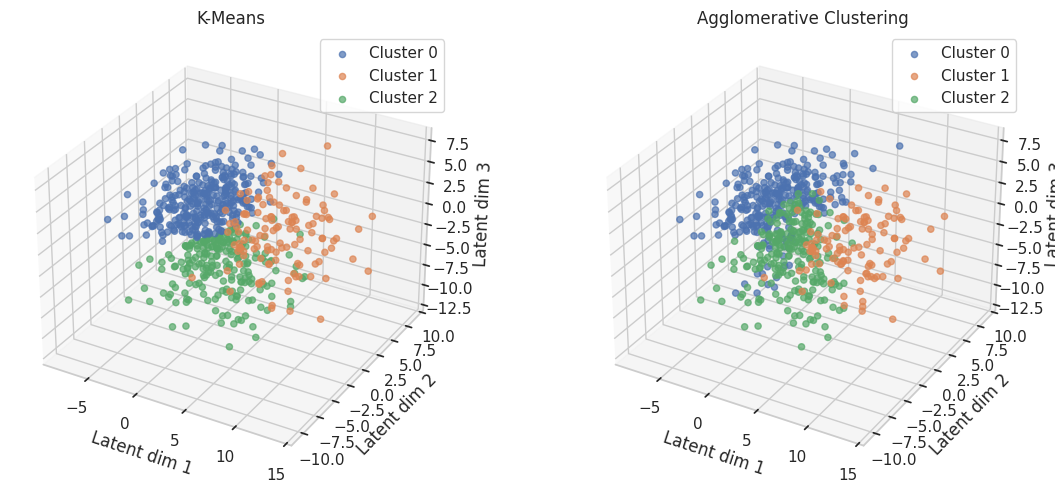

In [182]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.cluster import KMeans, AgglomerativeClustering

# Apply clustering to the embeddings
kmeans = KMeans(n_clusters=3, random_state=0, tol=1e-6, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(embeddings_after)

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
cluster_labels_agg = agg.fit_predict(embeddings_after)

def plot_latent_clusters_3d(latent_data, cluster_labels, title, ax, palette='Set1'):
    n_clusters = len(np.unique(cluster_labels))
    colors = sns.color_palette(palette, n_colors=n_clusters)
    for cluster in np.unique(cluster_labels):
        idx = cluster_labels == cluster
        ax.scatter(
            latent_data[idx, 0], latent_data[idx, 1], latent_data[idx, 2],
            label=f"Cluster {cluster}", alpha=0.7, 
        )
    ax.set_xlabel("Latent dim 1")
    ax.set_ylabel("Latent dim 2")
    ax.set_zlabel("Latent dim 3")
    ax.set_title(title)
    ax.legend()

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# 3D plot for K-Means clustering results
plot_latent_clusters_3d(embeddings_after, cluster_labels_kmeans, "K-Means", ax1)

# 3D plot for Agglomerative clustering results
plot_latent_clusters_3d(embeddings_after, cluster_labels_agg, "Agglomerative Clustering", ax2)

plt.tight_layout()
plt.show()

### Analysing results

- Each point represents a data sample in the latent space.
- Points close together are considered similar by the CNN.
- Clustering reveals **natural groupings** that the model has learned, even without labels.

In practice, you might use:
- `KMeans` (as shown here)
- `DBSCAN` (for density-based clustering)
- `AgglomerativeClustering` (hierarchical clustering)

If you have true labels (even just for validation), you can compare clustering quality using metrics like **ARI**, **NMI**, or **silhouette score**.

If you look careful you will see the the clusterings differ for each technique and that neither was able to faithfully reproduce the true data labels seen before. There is a lot of room for improvement, specially with the model and training. Let's take a look at the reconstruction of the inputs to see how we could improve the model.


### Reconstructed outputs

When training an autoencoder, it’s essential to look at how well the model can reconstruct the original inputs. By comparing the input signals to their reconstructions, we can visually assess how much information the model is able to capture and compress in its latent space.

If the reconstructions are very close to the original signals, it means the autoencoder has learned to represent the most important features of the data. On the other hand, if the reconstructions are poor or miss key patterns, it suggests the model is not learning enough or is too simple for the task.

Checking the reconstructed outputs helps us:
- **Diagnose underfitting or overfitting:** Are we losing important details, or is the model just memorizing the data?
- **Understand model limitations:** Are there certain types of signals the model struggles to reconstruct?
- **Build trust in the embeddings:** Good reconstructions mean the latent space is meaningful and useful for tasks like clustering or visualization.

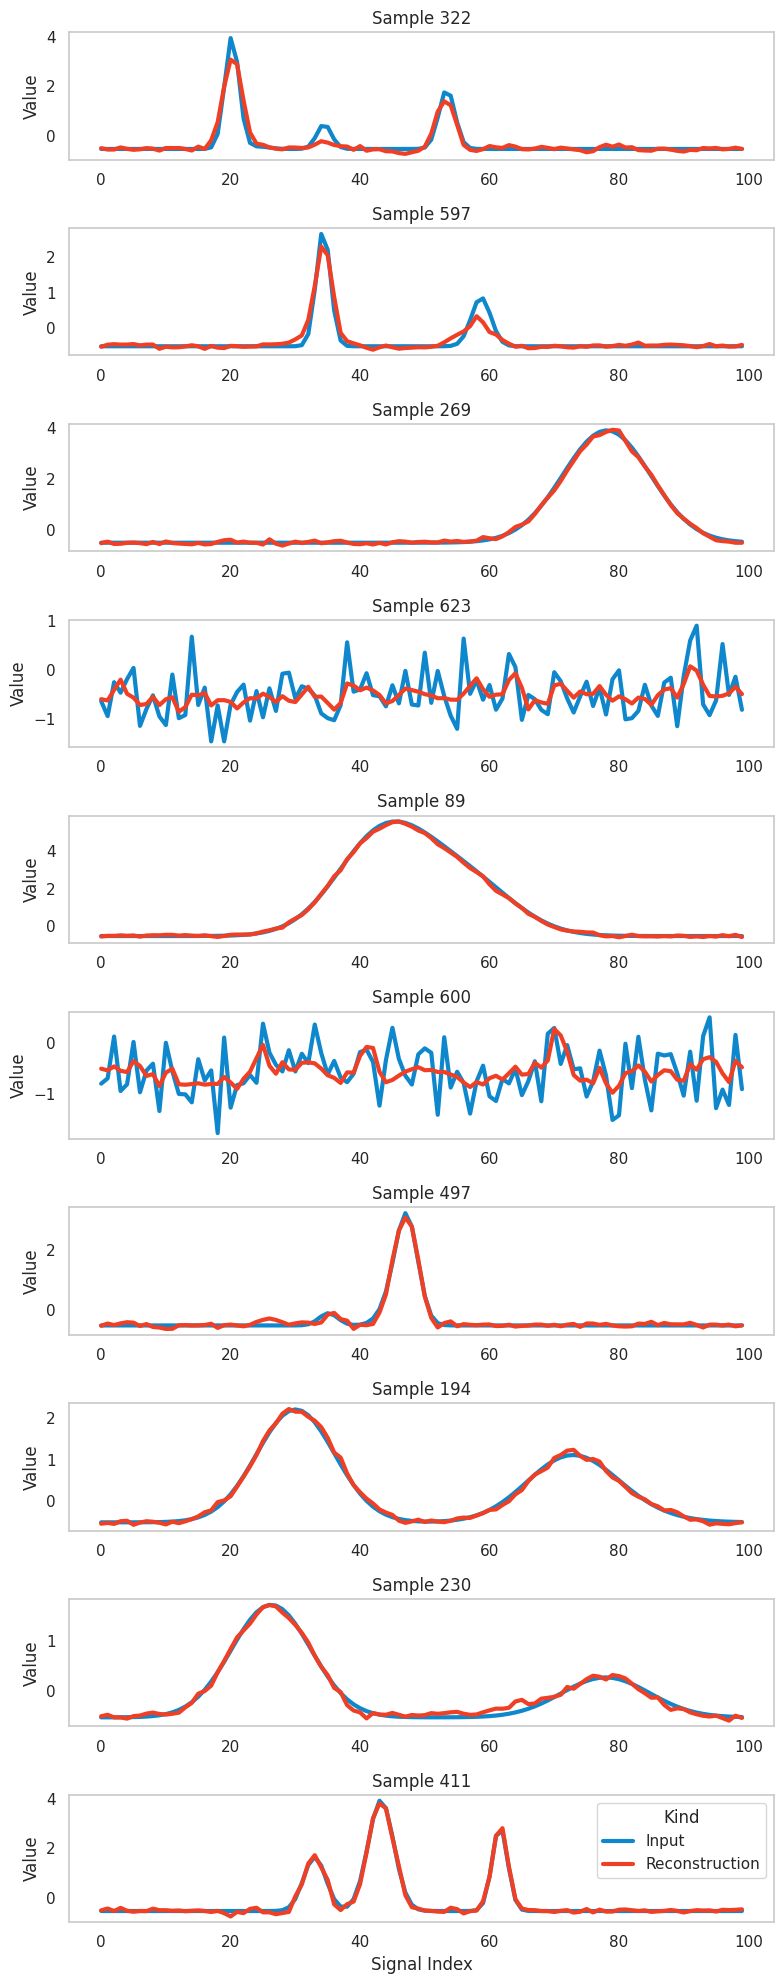

In [ ]:
# Plot input vs. reconstruction for a few random samples
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # Get reconstructions for the whole dataset
    recon, _ = model(dataset.unsqueeze(1))

# Convert to numpy for plotting
inputs = dataset.numpy()
recons = recon.squeeze(1).numpy()

n_samples_to_plot = 10
indices = np.random.choice(len(inputs), n_samples_to_plot, replace=False)

import seaborn as sns
import pandas as pd

# Prepare a DataFrame for seaborn
plot_rows = []
for i, idx in enumerate(indices):
    plot_rows.append({
        "Value": inputs[idx],
        "Signal Index": np.arange(inputs.shape[1]),
        "Kind": "Input",
        "Sample": i
    })
    plot_rows.append({
        "Value": recons[idx],
        "Signal Index": np.arange(recons.shape[1]),
        "Kind": "Reconstruction",
        "Sample": i
    })

# Flatten for seaborn
df_plot = pd.concat([
    pd.DataFrame({
        "Value": row["Value"],
        "Signal Index": row["Signal Index"],
        "Kind": row["Kind"],
        "Sample": row["Sample"]
    }) for row in plot_rows
], ignore_index=True)

plt.figure(figsize=(8, 2 * n_samples_to_plot))
for i in range(n_samples_to_plot):
    ax = plt.subplot(n_samples_to_plot, 1, i + 1)
    sns.lineplot(
        data=df_plot[df_plot["Sample"] == i],
        x="Signal Index",
        y="Value",
        hue="Kind",
        palette={"Input": "xkcd:water blue", "Reconstruction": "xkcd:tomato"},
        ax=ax,
        lw=3,
        legend=False if i < n_samples_to_plot - 1 else "auto"
    )
    ax.set_title(f"Sample {indices[i]}")
    ax.grid(False)
    if i < n_samples_to_plot - 1:
        ax.set_xlabel("")
plt.tight_layout()
plt.show()

There is clear room for improvement in our training, but the good sign is that it is clearly learning from the data. 

- The sharp peak details can be elusive for detection. The challenge lies in adjusting the network to be able to capture features from both broad and narrow peaks. 
- Noise data can be filtered from the dataset if the task is to better cluster narrow and broad peaks.

Try to change the network yourself and see some improvement!

# 🧠 Extra learning material

### Visualizing concepts:
- [Gentle dive into the maths](https://medium.com/data-science/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9)
- [CNNS for dummies](https://medium.com/@prathammodi001/convolutional-neural-networks-for-dummies-a-step-by-step-cnn-tutorial-e68f464d608f)

### Hands-on implementation examples
- [Autoencoder in PyTorch with CUDA](https://github.com/E008001/Autoencoder-in-Pytorch)
- [Friendly and well-explained tutorial](https://www.digitalocean.com/community/tutorials/convolutional-autoencoder)
- [Very complete tutorial](https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/)